In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [ ]:
acc_array_cumulants_rayleigh=[0.2500, 0.2458 ,   0.2542  ,  0.2833  ,  0.3167  ,  0.3958  ,  0.4125   , 0.5875  ,  0.6792 ,   0.7458  ,  0.8167 ,   0.8750,  0.9417 ,   0.9375 ,   0.9708 ,   0.9625]

In [ ]:
acc_array_cumulants_awgn=[0.247500,0.247500,0.267500,0.242500,0.260000,0.315000,0.457500,0.632500,0.845000,0.950000,0.985000,1.000000,1.000000,1.000000,1.000000,1.000000]

In [ ]:
np.mean(acc_array_cumulants_awgn)

NameError: ignored

**CNN Lite** 

In [ ]:
import numpy
snrs=numpy.arange(-10,21,2)

In [ ]:
snrs.shape

(16,)

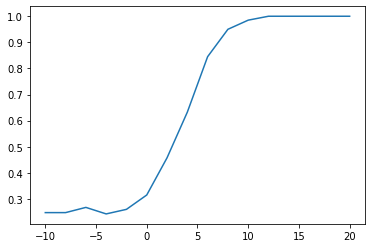

In [ ]:
import matplotlib.pyplot as plt
plt.plot(snrs,acc_array_cumulants_awgn)

In [ ]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import json

from keras import metrics, regularizers, optimizers, backend
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, Flatten, pooling
from keras.utils import np_utils, vis_utils

import scipy.io as sio

# fix random seed
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(2018)
rn.seed(2018)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=4)
tf.set_random_seed(2018)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
backend.set_session(sess)

seqLen = 128
nClass = 4
samNum = 100000 * nClass
# load train data
x_data_mat = sio.loadmat('/gdrive/My Drive/train_data_rayleigh_100k.mat')
x_data_complex = x_data_mat['train_data']
x_data_real = x_data_complex.real
x_data_imag = x_data_complex.imag
x_data_real = x_data_real.reshape((x_data_real.shape[0], seqLen, 1))
x_data_imag = x_data_imag.reshape((x_data_imag.shape[0], seqLen, 1))
x_train = np.stack((x_data_real, x_data_imag), axis=1)
y_data_mat = sio.loadmat('/gdrive/My Drive/train_label_rayleigh_100k.mat')
y_data = y_data_mat['train_label'][:,0]
y_snrs = y_data_mat['train_label'][:,1]
y_train = np_utils.to_categorical(y_data, nClass)
# train data shuffle
index = np.arange(y_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index,:]
y_train = y_train[index]

_in_ = Input(shape = (x_train.shape[1], x_train.shape[2], 1))
ot = Conv2D(filters=64, kernel_size=(2,4), strides=1, padding='valid', use_bias=True, activation='relu')(_in_)
ot = Conv2D(filters=16, kernel_size=(1,4), strides=1, padding='valid', use_bias=True, activation='relu')(ot)
ot = Flatten()(ot)
ot = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(ot)
ot = Dense(64, use_bias=True, activation='relu')(ot)
ot = Dense(16, use_bias=True, activation='relu')(ot)
_out_ = Dense(nClass, activation='softmax')(ot)
model = Model(_in_, _out_)

tensor_board = TensorBoard(log_dir='./tensorboard_log', histogram_freq=0, write_graph=True, write_images=False,
                            embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
               optimizer=adam, 
               metrics=['categorical_accuracy'])
model.summary()
model.fit(x_train,y_train, 
          epochs=100, 
          batch_size=128,
          validation_split=0.1,
          shuffle=True,callbacks=[early_stopping])

#scores = model.evaluate(x_train, y_train)
#print(" %s %f" % (model.metrics_names[1], scores[1]))
    


Using TensorFlow backend.







Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 125, 64)        576       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 122, 16)        4112      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1952)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1952)              7808      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                124992    
_________________________________________________________________
dense_2 (Dense)              (None, 16)               

In [ ]:
model.save_weights('/gdrive/My Drive/model_weights_cnn_lite_rayleigh.h5')

In [ ]:
model.load_weights('/gdrive/My Drive/model_weights_cnn_lite_awgn.h5')

In [ ]:
X_test_mat=sio.loadmat('/gdrive/My Drive/train_data_rayleigh_10k.mat')
Y_test_mat=sio.loadmat('/gdrive/My Drive/train_label_awgn_10k.mat')
X_test_complex = X_test_mat['train_data']
X_test_real = X_test_complex.real
X_test_imag = X_test_complex.imag
X_test_real = X_test_real.reshape((X_test_real.shape[0], seqLen, 1))
X_test_imag = X_test_imag.reshape((X_test_imag.shape[0], seqLen, 1))
X_test = np.stack((X_test_real, X_test_imag), axis=1)

In [ ]:
fucked=Y_test_mat['train_label']
Y_test=fucked[:,0]
Y_test_snrs=fucked[:,1]
Y_test=np_utils.to_categorical(Y_test,4)

score = model.evaluate(X_test, Y_test,  verbose=0)
print(score)
#test_Y_hat = model.predict(X_test)

ValueError: ignored

In [ ]:
acc_cnn2_awgn = {}

for snr in snrs:
    # extract classes @ SNR
    #test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(Y_test_snrs)==snr)]
    test_Y_i = Y_test[np.where(np.array(Y_test_snrs)==snr)]  
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([4,4])
    confnorm = np.zeros([4,4])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,4):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    print("snr=",snr)
    acc_cnn2_awgn[snr] = 1.0*cor/(cor+ncor)

Overall Accuracy:  0.3050430504305043
snr= -10
Overall Accuracy:  0.31946144430844553
snr= -8
Overall Accuracy:  0.40622537431048067
snr= -6
Overall Accuracy:  0.46064623032311514
snr= -4
Overall Accuracy:  0.5367118914604948
snr= -2
Overall Accuracy:  0.63469068128426
snr= 0
Overall Accuracy:  0.7892196299275945
snr= 2
Overall Accuracy:  0.8952496954933008
snr= 4
Overall Accuracy:  0.9693715194908512
snr= 6
Overall Accuracy:  0.9909341742215215
snr= 8
Overall Accuracy:  0.9984429739198132
snr= 10
Overall Accuracy:  1.0
snr= 12
Overall Accuracy:  1.0
snr= 14
Overall Accuracy:  1.0
snr= 16
Overall Accuracy:  1.0
snr= 18
Overall Accuracy:  1.0
snr= 20


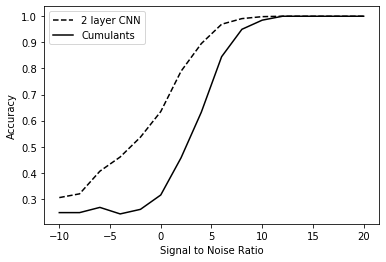

In [ ]:
plt.plot(snrs, list(map(lambda x: acc_cnn2_awgn[x], snrs)),'k--',label='2 layer CNN')
plt.plot(snrs, acc_array_cumulants_awgn,'k-',label='Cumulants')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/gdrive/My Drive/cnn2_vs_cum_awgn.png',figsize=(15,7.5), dpi= 100)	#save image

In [ ]:
list(map(lambda x: acc_cnn2_awgn[x], snrs))

[0.3050430504305043,
 0.31946144430844553,
 0.40622537431048067,
 0.46064623032311514,
 0.5367118914604948,
 0.63469068128426,
 0.7892196299275945,
 0.8952496954933008,
 0.9693715194908512,
 0.9909341742215215,
 0.9984429739198132,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

ValueError: ignored

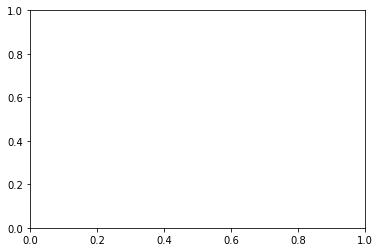

In [ ]:
plt.plot(snrs,acc,label='cnn')
plt.plot(snrs,acc_array_cumulants_awgn,label='cum')
plt.legend()



In [ ]:
x_train.shape

(400000, 2, 128, 1)

**CNN-2**

In [ ]:
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(2)   #disabled because we do not have a hardware GPU
import numpy as np
#import theano as th
#import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras.regularizers import *
from keras.optimizers import adam
from keras.optimizers import adagrad
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from keras.utils import multi_gpu_model
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf

In [ ]:
X=x_train.reshape(400000,2,128)

In [ ]:
y_train.shape

(400000, 4)

In [ ]:
X_train=X

In [ ]:
print('training started')
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)

training started
(400000, 2, 128) [2, 128]


In [ ]:
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
# error message occurs here!!!
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv1", activation="relu", data_format="channels_first", padding="valid", filters=256, kernel_size=(1, 3)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv2", activation="relu", data_format="channels_first", padding="valid", filters=256, kernel_size=(2, 3)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv3", activation="relu", data_format="channels_first", padding="valid", filters=80, kernel_size=(1, 3)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv4", activation="relu", data_format="channels_first", padding="valid", filters=80, kernel_size=(1, 3)))
model.add(Dropout(dr))
#model.add(ZeroPadding2D((0, 2), data_format="channels_first"))

model.add(Flatten())
# 128 (1) -> 11200; 64 (1/2) -> 6080; 32 (1/4) -> 3520; 16 (1/8) -> 2240; 8 (1/16) -> 1600; 4 (1/32) -> 1280
#model.add(Reshape((1,11200)))
#model.add(keras.layers.LSTM(50))
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( 4, init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([4]))
#opt=adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 256, 1, 132)       393472    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256, 1, 132)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, name="dense2", kernel_initializer="he_normal")`


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
               optimizer=adam, 
               metrics=['categorical_accuracy'])
model.fit(X,
          y_train, 
          epochs=100, 
          batch_size=128,
          validation_split=0.1,
          shuffle=True,
          callbacks=[early_stopping])

Train on 360000 samples, validate on 40000 samples
Epoch 1/100
360000/360000 [==============================] - 194s 539us/step - loss: 0.5577 - categorical_accuracy: 0.6969 - val_loss: 0.4488 - val_categorical_accuracy: 0.7710
Epoch 2/100
360000/360000 [==============================] - 191s 531us/step - loss: 0.4348 - categorical_accuracy: 0.7758 - val_loss: 0.4253 - val_categorical_accuracy: 0.7872
Epoch 3/100
360000/360000 [==============================] - 191s 530us/step - loss: 0.4276 - categorical_accuracy: 0.7786 - val_loss: 0.4294 - val_categorical_accuracy: 0.7756
Epoch 4/100
360000/360000 [==============================] - 191s 529us/step - loss: 0.4259 - categorical_accuracy: 0.7794 - val_loss: 0.4412 - val_categorical_accuracy: 0.7728
Epoch 5/100
360000/360000 [==============================] - 190s 529us/step - loss: 0.4242 - categorical_accuracy: 0.7802 - val_loss: 0.4310 - val_categorical_accuracy: 0.7696
Epoch 6/100
360000/360000 [==============================] - 190

In [ ]:
model.save_weights('/gdrive/My Drive/cnn4_weights_awgn.h5')

In [ ]:
model.load_weights('/gdrive/My Drive/cnn4_weights_rayleigh.h5')

In [ ]:
score = model.evaluate(X_test.reshape(40000,2,128), Y_test,  verbose=0)
print(score)

0.6892583538532258


In [ ]:
acc_cnn4_awgn = {}

for snr in snrs:
    # extract classes @ SNR
    #test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(Y_test_snrs)==snr)]
    test_Y_i = Y_test[np.where(np.array(Y_test_snrs)==snr)]  
    test_Y_i_hat = model.predict(test_X_i.reshape(test_X_i.shape[0],2,128))
    conf = np.zeros([4,4])
    confnorm = np.zeros([4,4])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,4):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    print("snr=",snr)
    acc_cnn4_awgn[snr] = 1.0*cor/(cor+ncor)

Overall Accuracy:  0.6391963919639196
snr= -10
Overall Accuracy:  0.6368829049367605
snr= -8
Overall Accuracy:  0.6379038613081166
snr= -6
Overall Accuracy:  0.6512013256006628
snr= -4
Overall Accuracy:  0.6340782122905028
snr= -2
Overall Accuracy:  0.6456538762725137
snr= 0
Overall Accuracy:  0.6432019308125503
snr= 2
Overall Accuracy:  0.6358099878197321
snr= 4
Overall Accuracy:  0.6308671439936356
snr= 6
Overall Accuracy:  0.6373669688608593
snr= 8
Overall Accuracy:  0.650058388478007
snr= 10
Overall Accuracy:  0.6360465116279069
snr= 12
Overall Accuracy:  0.6518811881188119
snr= 14
Overall Accuracy:  0.6426868044515104
snr= 16
Overall Accuracy:  0.6476578411405295
snr= 18
Overall Accuracy:  0.6587851610273135
snr= 20


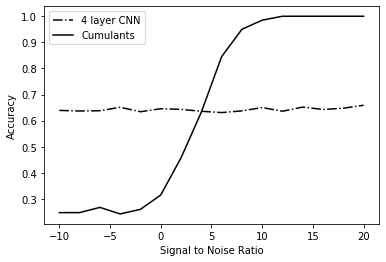

In [ ]:
plt.plot(snrs, list(map(lambda x: acc_cnn4_awgn[x], snrs)),'k-.',label='4 layer CNN')
plt.plot(snrs, acc_array_cumulants_awgn,'k-',label='Cumulants')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/gdrive/My Drive/cnn4_vs_cum_awgn.png',figsize=(15,7.5), dpi= 100)	#save image

In [ ]:
list(map(lambda x: acc_cnn4_awgn[x], snrs))

[0.33989339893398934,
 0.379436964504284,
 0.4105594956658786,
 0.4660314830157415,
 0.5287310454908221,
 0.5411119812059515,
 0.6403861625100563,
 0.8205440519691434,
 0.9419252187748608,
 0.9862041781631848,
 0.9968859478396264,
 0.9988372093023256,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
np.mean(list(map(lambda x: acc_cnn4_awgn[x], snrs)))

0.7531591960859916

**CLDNN**

In [ ]:
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
# error message occurs here!!!
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv1", activation="relu", data_format="channels_first", padding="valid", filters=256, kernel_size=(1, 3)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv2", activation="relu", data_format="channels_first", padding="valid", filters=256, kernel_size=(2, 3)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv3", activation="relu", data_format="channels_first", padding="valid", filters=80, kernel_size=(1, 3)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv4", activation="relu", data_format="channels_first", padding="valid", filters=80, kernel_size=(1, 3)))
model.add(Dropout(dr))
#model.add(ZeroPadding2D((0, 2), data_format="channels_first"))

model.add(Flatten())
# 128 (1) -> 11200; 64 (1/2) -> 6080; 32 (1/4) -> 3520; 16 (1/8) -> 2240; 8 (1/16) -> 1600; 4 (1/32) -> 1280
model.add(Reshape((1,10880)))
model.add(keras.layers.LSTM(50))
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( 4, init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([4]))
#opt=adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
#The shape of the input to "Flatten" is not fully defined (got (0, 6, 80). 
#Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 256, 1, 132)       393472    
____

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, name="dense2", kernel_initializer="he_normal")`


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
               optimizer=adam, 
               metrics=['categorical_accuracy'])
model.fit(X,
          y_train, 
          epochs=100, 
          batch_size=128,
          validation_split=0.1,
          shuffle=True,callbacks=[early_stopping])

Train on 360000 samples, validate on 40000 samples
Epoch 1/100
360000/360000 [==============================] - 209s 581us/step - loss: 0.9680 - categorical_accuracy: 0.4790 - val_loss: 0.7519 - val_categorical_accuracy: 0.6285
Epoch 2/100
360000/360000 [==============================] - 206s 571us/step - loss: 0.7301 - categorical_accuracy: 0.6287 - val_loss: 0.7267 - val_categorical_accuracy: 0.6321
Epoch 3/100
360000/360000 [==============================] - 206s 571us/step - loss: 0.7177 - categorical_accuracy: 0.6360 - val_loss: 0.7183 - val_categorical_accuracy: 0.6298
Epoch 4/100
360000/360000 [==============================] - 205s 570us/step - loss: 0.7119 - categorical_accuracy: 0.6382 - val_loss: 0.7154 - val_categorical_accuracy: 0.6386
Epoch 5/100
360000/360000 [==============================] - 206s 571us/step - loss: 0.7100 - categorical_accuracy: 0.6386 - val_loss: 0.6996 - val_categorical_accuracy: 0.6465
Epoch 6/100
360000/360000 [==============================] - 205

In [ ]:
model.save_weights('/gdrive/My Drive/model_weights_cldnn_rayleigh.h5')

In [ ]:
model.load_weights('/gdrive/My Drive/model_weights_cldnn_rayleigh.h5')

In [ ]:
score = model.evaluate(X_test.reshape(40000,2,128), Y_test,  verbose=0)
print(score)

0.7864005355358124


In [ ]:
acc_cldnn_rayleigh = {}

for snr in snrs:
    # extract classes @ SNR
    #test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(Y_test_snrs)==snr)]
    test_Y_i = Y_test[np.where(np.array(Y_test_snrs)==snr)]  
    test_Y_i_hat = model.predict(test_X_i.reshape(test_X_i.shape[0],2,128))
    conf = np.zeros([4,4])
    confnorm = np.zeros([4,4])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,4):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    print("snr=",snr)
    acc_cldnn_rayleigh[snr] = 1.0*cor/(cor+ncor)

Overall Accuracy:  0.6109061090610907
snr= -10
Overall Accuracy:  0.6017951856385149
snr= -8
Overall Accuracy:  0.594956658786446
snr= -6
Overall Accuracy:  0.6151615575807788
snr= -4
Overall Accuracy:  0.6001596169193935
snr= -2
Overall Accuracy:  0.6119812059514487
snr= 0
Overall Accuracy:  0.6106194690265486
snr= 2
Overall Accuracy:  0.5988631749898498
snr= 4
Overall Accuracy:  0.5966587112171837
snr= 6
Overall Accuracy:  0.6192353173039022
snr= 8
Overall Accuracy:  0.6072401712728688
snr= 10
Overall Accuracy:  0.608139534883721
snr= 12
Overall Accuracy:  0.6182178217821782
snr= 14
Overall Accuracy:  0.6228139904610492
snr= 16
Overall Accuracy:  0.604480651731161
snr= 18
Overall Accuracy:  0.6110884631064003
snr= 20


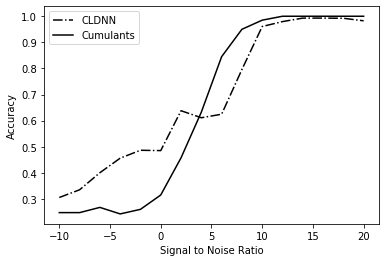

In [ ]:
plt.plot(snrs, list(map(lambda x: acc_cnn4_awgn[x], snrs)),'k-.',label='CLDNN')
plt.plot(snrs, acc_array_cumulants_awgn,'k-',label='Cumulants')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/My Drive/cldnn_vs_cum_awgn.png',figsize=(15,7.5), dpi= 100)	#save image

In [ ]:
list(map(lambda x: acc_cnn4_awgn[x], snrs))

[0.30545305453054533,
 0.3349653202774378,
 0.40031520882584715,
 0.45608947804473904,
 0.48643256185155626,
 0.4851213782302271,
 0.6379726468222043,
 0.611043442955745,
 0.624502784407319,
 0.795821836815136,
 0.9606850914752822,
 0.9794573643410853,
 0.9928712871287129,
 0.9928457869634341,
 0.9922606924643584,
 0.9824704443538524]

In [ ]:
list(map(lambda x: acc_cldnn_rayleigh[x], snrs))

[0.6109061090610907,
 0.6017951856385149,
 0.594956658786446,
 0.6151615575807788,
 0.6001596169193935,
 0.6119812059514487,
 0.6106194690265486,
 0.5988631749898498,
 0.5966587112171837,
 0.6192353173039022,
 0.6072401712728688,
 0.608139534883721,
 0.6182178217821782,
 0.6228139904610492,
 0.604480651731161,
 0.6110884631064003]